In [1]:
from __future__ import annotations
import numpy as np
from img.img_handeler import ImgHandler
from np_labels.label_handeler import LabelHandeler as BlobHandeler
import tifffile

In [7]:
import cv2
def RemoveScaleBar(self, intensity_threshold=240, min_area=500, aspect_ratio_thresh=4.0):
    """
    Detects and removes the scale bar, intelligently filling it with a gradient
    interpolated from the pixel values on either side.

    Returns:
        np.ndarray: Image with scale bar removed and region inpainted.
    """
    img = self.raw_image.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) if img.ndim == 3 else img.copy()

    # Detect bright rectangular regions
    _, binary = cv2.threshold(gray, intensity_threshold, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = cv2.contourArea(cnt)
        aspect_ratio = max(w / h, h / w)

        if area > min_area and aspect_ratio > aspect_ratio_thresh:
            # We'll fill in this region
            region = (slice(y, y + h), slice(x, x + w))

            if w >= h:
                # Horizontal bar: interpolate top to bottom
                top = img[y - 1, x:x + w].astype(np.float32) if y > 0 else img[y + h, x:x + w].astype(np.float32)
                bottom = img[y + h, x:x + w].astype(np.float32) if y + h < img.shape[0] else top
                for i in range(h):
                    weight = i / max(1, h - 1)
                    interpolated = ((1 - weight) * top + weight * bottom).astype(np.uint8)
                    img[y + i, x:x + w] = interpolated

            else:
                # Vertical bar: interpolate left to right
                left = img[y:y + h, x - 1].astype(np.float32)[:, None] if x > 0 else img[y:y + h, x + w].astype(np.float32)[:, None]
                right = img[y:y + h, x + w].astype(np.float32)[:, None] if x + w < img.shape[1] else left
                for i in range(w):
                    weight = i / max(1, w - 1)
                    interpolated = ((1 - weight) * left + weight * right).astype(np.uint8)
                    img[y:y + h, x + i] = interpolated

    self.current_image = img
    return img

ImgHandler.InconvenientObjectRemover = RemoveScaleBar

In [8]:
import cv2
import matplotlib.pyplot as plt

# Example usage
image = tifffile.imread('/home/user/documents/PiereLab/lysozyme/DemoData/G2-ABX/G2-ABX/G2FL - 4.tif')
image = ImgHandler.InconvenientObjectRemover(image).RemoveScaleBar(intensity_threshold=240, min_area=500, aspect_ratio_thresh=4.0)

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'raw_image'

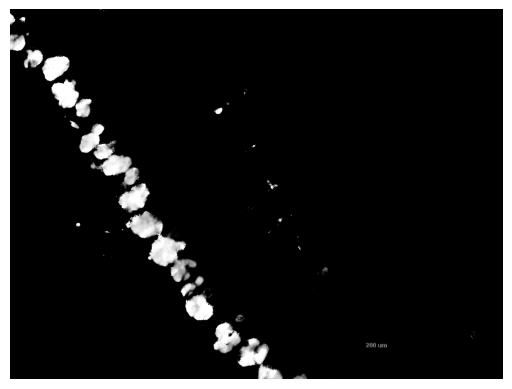

In [3]:
positive_mask = ImgHandler.transform.threshold.chromaticity(image, channel=0, threshold=0.5)
plt.imshow(positive_mask, cmap='gray')
plt.axis('off')
plt.show()

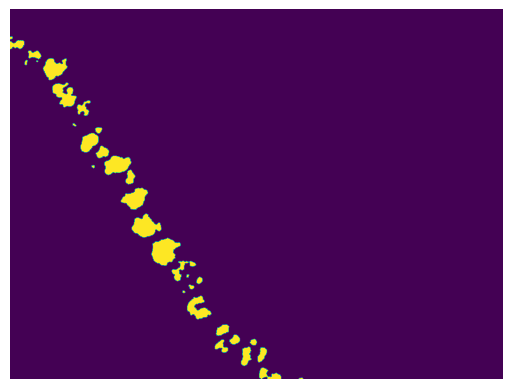

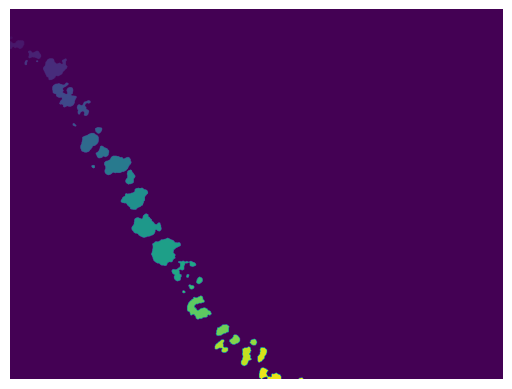

In [4]:
cleaned_mask = ImgHandler.masker(ImgHandler.EnhanceContrast.CLAHE(ImgHandler.transform.gray_scale.single_channel(image, channel=0))).otsu().morph_cleanup().cleaned_mask

labels = ImgHandler.segmentation.region_based_segmentation.water_shed_segmentation(
                    
                        cleaned_mask,
                    low_thresh=10, high_thresh=150
                )
plt.imshow(cleaned_mask)
plt.axis('off')
plt.show()
plt.imshow(labels)
plt.axis('off')
plt.show()